In [1]:
import os
if "GOOGLE_API_KEY" not in os.environ:
        os.environ["GOOGLE_API_KEY"] = os.environ["GEMINI_API_KEY"]

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash" ,temperature=0)

# _set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"



In [2]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from operator import add

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    # human_analyst_feedback: str # Human feedback
    human_analyst_feedback: Annotated[List[str], add]  # Human feedback
    analysts: Annotated[List[Analyst], add] 
    final_analysts: List[Analyst] #= Field(..., min_items=3, max_items=3, description="Exactly 3 related sub-topics")# Analyst asking questions

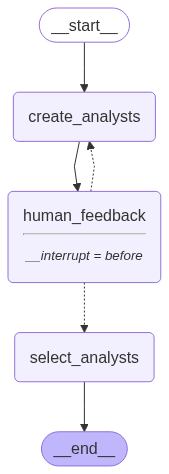

In [3]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

selector_instructions="""You are tasked with selecting {max_analysts} AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Here are the candidates:
{candidates}
                    
4. Pick {max_analysts} analysts suitable for researching about {topic}. Make sure to select no more and no less than {max_analysts} analysts.
"""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    # human_analyst_feedback=state.get('human_analyst_feedback', '')
    # import pdb; pdb.set_trace()
    human_analyst_feedback=state.get('human_analyst_feedback', [])
    if human_analyst_feedback:
        human_analyst_feedback = human_analyst_feedback[-1]
    else:
        human_analyst_feedback = ""
                
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def select_analysts(state: GenerateAnalystsState):
    
    """ Select analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', [])
    human_analyst_feedback = "\n".join(feedback for feedback in human_analyst_feedback if feedback)
    candidates = state.get('analysts', [])
    candidates = "\n\n".join(analyst.persona for analyst in candidates)
                
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = selector_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts,
                                                            candidates=candidates)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Pick the {max_analysts} analysts.")])
    
    # Write the list of analysis to state
    return {"final_analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', [None])
    if len(human_analyst_feedback) > 0:
        human_analyst_feedback = human_analyst_feedback[-1]
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return "select_analysts"

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("select_analysts", select_analysts)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", "select_analysts"])
builder.add_edge("select_analysts", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [4]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

# graph.invoke({"topic":topic,"max_analysts":max_analysts,}, thread)

Name: Dr. Anya Sharma
Affiliation: AI Research Institute
Role: AI Agent Architect
Description: Focuses on the technical advantages of LangGraph, such as its ability to manage complex conversational flows and improve agent reliability. They are motivated by advancing the state-of-the-art in AI agent technology.
--------------------------------------------------
Name: Raj Patel
Affiliation: Large Language Model Start-up
Role: Lead Product Manager
Description: Concerned with the practical benefits of LangGraph for rapid prototyping and deployment of AI agents. They are motivated by quickly launching new products and features.
--------------------------------------------------
Name: Professor Emily Carter
Affiliation: AI Ethics and Society Watchdog
Role: AI Ethics Researcher
Description: Interested in the ethical implications of using LangGraph, particularly regarding transparency, bias, and control in AI agent interactions. They are motivated by ensuring responsible AI development and dep

In [5]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [6]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            ["Add in someone from a startup to add an entrepreneur perspective"]}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03d310-f573-6f27-8002-c4ec9e7425b9'}}

In [7]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: AI Research Institute
Role: AI Agent Architect
Description: Focuses on the technical advantages of LangGraph, such as its ability to manage complex conversational flows and improve agent reliability. They are motivated by advancing the state-of-the-art in AI agent technology.
--------------------------------------------------
Name: Raj Patel
Affiliation: Large Language Model Start-up
Role: Lead Product Manager
Description: Concerned with the practical benefits of LangGraph for rapid prototyping and deployment of AI agents. They are motivated by quickly launching new products and features.
--------------------------------------------------
Name: Professor Emily Carter
Affiliation: AI Ethics and Society Watchdog
Role: AI Ethics Researcher
Description: Interested in the ethical implications of using LangGraph, particularly regarding transparency, bias, and control in AI agent interactions. They are motivated by ensuring responsible AI development and dep

In [8]:
graph.update_state(thread, {"human_analyst_feedback": 
                            ["It would be great to have some perspective from the open source community"]}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03d311-0808-6c1a-8004-098e90a113bb'}}

In [9]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="updates"):
    # Review
    create_analysts = event.get('create_analysts', '')
    if create_analysts:
        analysts = create_analysts.get('analysts', [])
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)
    

Name: Ava Chen
Affiliation: Open Source Contributor
Role: Open Source Advocate
Description: Focuses on the ease of integration and community support for LangGraph. They value frameworks that are well-documented, easy to contribute to, and have a vibrant community.
--------------------------------------------------


In [10]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            [further_feedack]}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03d311-1375-6dd9-8006-9bb6eaa7fb49'}}

In [11]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
select_analysts


In [12]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
final_analysts = final_state.values.get('final_analysts')

In [13]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: AI Research Institute
Role: AI Agent Architect
Description: Focuses on the technical advantages of LangGraph, such as its ability to manage complex conversational flows and improve agent reliability. They are motivated by advancing the state-of-the-art in AI agent technology.
--------------------------------------------------
Name: Raj Patel
Affiliation: Large Language Model Start-up
Role: Lead Product Manager
Description: Concerned with the practical benefits of LangGraph for rapid prototyping and deployment of AI agents. They are motivated by quickly launching new products and features.
--------------------------------------------------
Name: Professor Emily Carter
Affiliation: AI Ethics and Society Watchdog
Role: AI Ethics Researcher
Description: Interested in the ethical implications of using LangGraph, particularly regarding transparency, bias, and control in AI agent interactions. They are motivated by ensuring responsible AI development and dep

In [14]:
print("Final Analysts:")
for analyst in final_analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Final Analysts:
Name: Ben Carter
Affiliation: AI Startup
Role: Founder & CEO
Description: Interested in LangGraph's potential for rapid prototyping and innovation. Highly motivated by its ability to accelerate development cycles and create novel AI-powered products with limited resources.
--------------------------------------------------
Name: Ava Chen
Affiliation: Open Source Contributor
Role: Open Source Advocate
Description: Focuses on the ease of integration and community support for LangGraph. They value frameworks that are well-documented, easy to contribute to, and have a vibrant community.
--------------------------------------------------
Name: Raj Patel
Affiliation: Large Language Model Start-up
Role: Lead Product Manager
Description: Concerned with the practical benefits of LangGraph for rapid prototyping and deployment of AI agents. They are motivated by quickly launching new products and features.
--------------------------------------------------
